In [1]:
import json
import tensorflow as tf
from tensorflow.keras import Input
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout, BatchNormalization, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping

# Configuring TensorFlow to use GPU
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


#### Datasets

In [2]:
x_train_cell_lines = pd.read_csv('../data/splits/train/x_train_cell_lines.csv', index_col=0)
x_train_drugs = pd.read_csv('../data/splits/train/x_train_drugs.csv', index_col=0)
y_train = pd.read_csv('../data/splits/train/y_train.csv', index_col=0)

x_test_cell_lines = pd.read_csv('../data/splits/test/x_test_cell_lines.csv', index_col=0)
x_test_drugs = pd.read_csv('../data/splits/test/x_test_drugs.csv', index_col=0)
y_test = pd.read_csv('../data/splits/test/y_test.csv', index_col=0)

x_val_cell_lines = pd.read_csv('../data/splits/val/x_val_cell_lines.csv', index_col=0)
x_val_drugs = pd.read_csv('../data/splits/val/x_val_drugs.csv', index_col=0)
y_val = pd.read_csv('../data/splits/val/y_val.csv', index_col=0)

In [3]:
x_train_drugs

,Drug
Dabrafenib_SW1710,CC(C)(C)C1=NC(=C(S1)C2=NC(=NC=C2)N)C3=C(C(=CC=...
Lapatinib_TGW,CS(=O)(=O)CCNCC1=CC=C(O1)C2=CC3=C(C=C2)N=CN=C3...
Ruxolitinib_GCT,C1CCC(C1)[C@@H](CC#N)N2C=C(C=N2)C3=C4C=CNC4=NC=N3
MN-64_EW-24,CC(C)C1=CC=C(C=C1)C2=CC(=O)C3=CC=CC=C3O2
Sapitinib_NCI-H1869,CNC(=O)CN1CCC(CC1)OC2=C(C=C3C(=C2)C(=NC=N3)NC4...
...,...
PFI3_SW1463,C1[C@@H]2CN([C@H]1CN2C3=CC=CC=N3)/C=C/C(=O)C4=...
I-BRD9_SW1710,CCN1C=C(C2=C(C1=O)C=C(S2)C(=NC3CCS(=O)(=O)CC3)...
Olaparib_RERF-GC-1B,C1CC1C(=O)N2CCN(CC2)C(=O)C3=C(C=CC(=C3)CC4=NNC...
Crizotinib_HCC2218,C[C@H](C1=C(C=CC(=C1Cl)F)Cl)OC2=C(N=CC(=C2)C3=...


In [4]:
x_train_cell_lines

,FUCA2,GCLC,STPG1,CYP26B1,NDUFAB1,ABCB5,DVL2,HOXA11,COPZ2,CREBBP,...,ATP6V1E2,ZNF345,ATXN7L3B,PRKDC,PBOV1,OR13A1,ZNF253,MRPL46,OR1D5,MYH4
Dabrafenib_SW1710,7.920898,5.369301,3.820045,2.893578,10.140094,2.888785,4.808708,3.838261,5.110550,5.442045,...,3.964336,4.023004,5.336447,6.466790,2.940953,3.332759,3.889705,7.408880,3.686703,2.593133
Lapatinib_TGW,4.086446,6.715755,3.152207,2.977787,11.495806,2.832806,5.748287,2.788454,3.656858,6.440322,...,4.428327,5.174020,7.852960,7.595099,3.038144,3.323596,2.739460,8.336177,3.337451,2.441808
Ruxolitinib_GCT,8.272114,5.417548,3.558538,3.053982,11.082245,2.823397,6.046880,4.953580,5.376569,5.403302,...,4.057561,2.942980,5.114811,6.261316,3.013983,3.076459,3.841630,8.332464,3.155997,2.544252
MN-64_EW-24,3.324724,4.391741,3.439392,6.849185,11.444114,3.069665,5.608626,2.964643,4.407107,6.767137,...,4.848096,4.416856,6.666332,6.872747,3.023575,3.449833,3.458194,9.104475,3.925635,2.662439
Sapitinib_NCI-H1869,7.296754,8.546812,3.664518,3.362914,10.627687,3.029736,4.349724,3.369286,4.738751,5.501484,...,3.986183,3.943430,5.563829,5.932634,2.925860,3.530848,4.134750,8.301205,3.474793,2.756528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PFI3_SW1463,7.851452,6.143533,3.774689,2.937680,11.339133,3.043644,4.580882,5.089882,3.330522,5.595879,...,4.793499,4.738768,6.726044,5.808590,2.832737,3.678759,4.410979,8.231673,3.377068,3.009807
I-BRD9_SW1710,7.920898,5.369301,3.820045,2.893578,10.140094,2.888785,4.808708,3.838261,5.110550,5.442045,...,3.964336,4.023004,5.336447,6.466790,2.940953,3.332759,3.889705,7.408880,3.686703,2.593133
Olaparib_RERF-GC-1B,7.103327,6.057814,3.285193,2.881877,11.527119,2.978740,5.526652,3.157037,4.615804,6.645393,...,5.960230,6.854925,6.428696,6.726985,2.792515,3.375117,3.350753,8.907326,3.454210,2.510775
Crizotinib_HCC2218,7.205591,5.356177,3.342622,2.919920,11.388315,3.095454,4.328444,3.060736,3.731668,5.786437,...,4.061743,3.632399,6.157377,6.432589,3.374558,3.612480,3.698259,8.743277,3.809671,2.523288


### Featurizer ###

In [5]:
from featurizers import GraphFeaturizer

featurizer_train = GraphFeaturizer()
node_features_train, adjacency_matrix_train = featurizer_train.featurize_df(x_train_drugs[:10000], 'Drug')

featurizer_val = GraphFeaturizer()
node_features_val, adjacency_matrix_val = featurizer_val.featurize_df(x_val_drugs[:5000], 'Drug')

featurizer_test = GraphFeaturizer()
node_features_test, adjacency_matrix_test = featurizer_test.featurize_df(x_test_drugs[:5000], 'Drug')


Skipped loading some PyTorch models, missing a dependency. No module named 'torch'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch'
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'torch'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


### Drug GCN model

In [10]:
from models import DrugGCNModel


# Example usage

model = DrugGCNModel(expr_dim=x_train_cell_lines.shape[1], optimizer='Adam', learn_rate=0.0001)
print(model.summary())
model.train(x_train_cell_lines[:10000], node_features_train, adjacency_matrix_train, y_train[:10000], epochs=100, batch_size=16)

val_loss, val_mae = model.evaluate(x_val_cell_lines[:5000], node_features_val, adjacency_matrix_val, y_val[:5000])
print(f'Test Loss: {val_loss}, Test MAE: {val_mae}')

predictions = model.predict(x_test_cell_lines[:5000], node_features_test, adjacency_matrix_test)
print(predictions)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 cell_line_input (InputLayer)   [(None, 2089)]       0           []                               
                                                                                                  
 dense_4 (Dense)                (None, 10)           20900       ['cell_line_input[0][0]']        
                                                                                                  
 activation_2 (Activation)      (None, 10)           0           ['dense_4[0][0]']                
                                                                                                  
 drug_nodes_input (InputLayer)  [(None, None, 30)]   0           []                               
                                                                                            

c:\Users\Paulo Seixal\anaconda3\envs\drug39\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


None
Epoch 1/100
500/500 [==============================] - 4s 7ms/step - loss: 13.6136 - mae: 3.2636 - val_loss: 11.4083 - val_mae: 2.9510
Epoch 2/100
 22/500 [>.............................] - ETA: 2s - loss: 13.8190 - mae: 3.3394

c:\Users\Paulo Seixal\anaconda3\envs\drug39\lib\site-packages\keras\engine\functional.py:1563: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


500/500 [==============================] - 3s 6ms/step - loss: 12.2979 - mae: 3.0769 - val_loss: 9.9659 - val_mae: 2.7204
Epoch 3/100
500/500 [==============================] - 4s 7ms/step - loss: 11.0532 - mae: 2.8856 - val_loss: 8.3233 - val_mae: 2.4219
Epoch 4/100
500/500 [==============================] - 3s 7ms/step - loss: 9.7939 - mae: 2.6774 - val_loss: 7.4816 - val_mae: 2.2493
Epoch 5/100
500/500 [==============================] - 3s 7ms/step - loss: 8.6862 - mae: 2.4766 - val_loss: 6.7981 - val_mae: 2.0842
Epoch 6/100
500/500 [==============================] - 3s 7ms/step - loss: 7.7999 - mae: 2.3037 - val_loss: 6.4660 - val_mae: 1.9808
Epoch 7/100
500/500 [==============================] - 3s 7ms/step - loss: 7.0725 - mae: 2.1588 - val_loss: 6.2396 - val_mae: 1.8939
Epoch 8/100
500/500 [==============================] - 3s 7ms/step - loss: 6.5451 - mae: 2.0432 - val_loss: 6.2960 - val_mae: 1.8722
Epoch 9/100
500/500 [==============================] - 3s 6ms/step - loss: 6.32

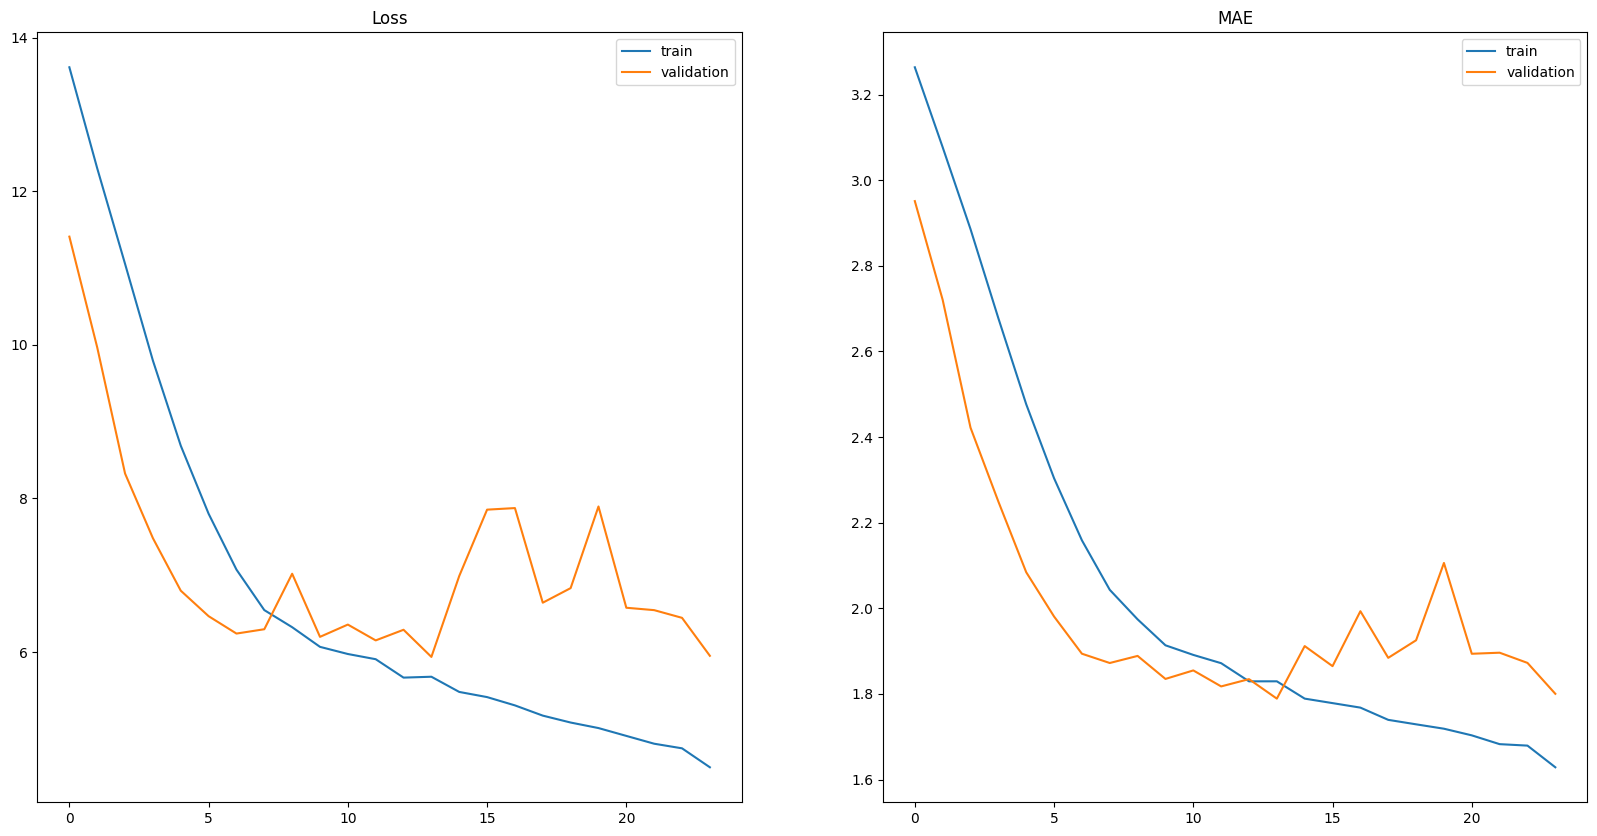

In [11]:
#plot loss and mae from training and validation data side by side
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(model.history.history['loss'], label='train')
plt.plot(model.history.history['val_loss'], label='validation')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(model.history.history['mae'], label='train')
plt.plot(model.history.history['val_mae'], label='validation')
plt.title('MAE')
plt.legend()
plt.show()





In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


print('GCN model')
print('MAE: ', mean_absolute_error(y_test[:5000], predictions))
print('MSE: ', mean_squared_error(y_test[:5000], predictions))
print('RMSE: ', np.sqrt(mean_squared_error(y_test[:5000], predictions)))
print('R2: ', r2_score(y_test[:5000], predictions))

GCN model
MAE:  1.8168711119370906
MSE:  5.869792439534647
RMSE:  2.4227654528523077
R2:  0.23374925036457417
